# Stencil Computation for 2D Heat Diffusion Simulation Using Julia 

In [1]:
#using Pkg
#Pkg.add("CUDA")

In [2]:
#import Pkg
#Pkg.add("BenchmarkTools")

In [23]:
#import Pkg
#Pkg.add("ProgressMeter")

In [4]:
#import Pkg
#Pkg.add("KernelAbstractions")

In [5]:
#import Pkg
#Pkg.add("CairoMakie")

In [1]:
using CUDA

In [2]:
using BenchmarkTools # for benchmarking

In [1]:
using CairoMakie # for plotting

In [35]:
using ProgressMeter

In CUDA.jl check if the package is functional, you can call the `versioninfo()` function. Like `Base.versioninfo()`, this will print some information on the available hardware and loaded libraries:

# Stencil Computation

# 2D Stencil Computation and the Heat Equation

In computational science, stencil computations are a common method for solving partial differential equations (PDEs) like the heat equation. The heat equation in two dimensions models the distribution of heat (or temperature) in a region over time. It is defined by:

$$
\frac{\partial u}{\partial t} = \alpha \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

where:
- $u(x, y, t)$ represents the temperature at location $(x, y)$ and time $t$,
- $ \alpha $ is the thermal diffusivity constant of the material.

To numerically approximate this equation, we discretize both time and space, creating a grid over which we compute temperature values at each grid point for successive time steps. A common approach is to use a finite-difference stencil method, specifically a 5-point stencil in 2D. For spatial discretization, this involves a simple update rule that incorporates the values of \( u \) at neighboring points.

## Discretization in 2D

Let:
- $ \Delta x$ and $ \Delta y$ be the spatial steps in the $ x$- and $y$-directions, respectively.
- $ \Delta t$ be the time step.

Using the central difference approximation for the spatial derivatives, we can approximate the heat equation at each grid point \((i, j)\) as:

$$
\frac{u_{i,j}^{n+1} - u_{i,j}^{n}}{\Delta t} = \alpha \left( \frac{u_{i+1,j}^{n} - 2u_{i,j}^{n} + u_{i-1,j}^{n}}{\Delta x^2} + \frac{u_{i,j+1}^{n} - 2u_{i,j}^{n} + u_{i,j-1}^{n}}{\Delta y^2} \right)
$$

This equation can be rearranged to give the explicit update rule:

$$
u_{i,j}^{n+1} = u_{i,j}^{n} + \alpha \Delta t \left( \frac{u_{i+1,j}^{n} - 2u_{i,j}^{n} + u_{i-1,j}^{n}}{\Delta x^2} + \frac{u_{i,j+1}^{n} - 2u_{i,j}^{n} + u_{i,j-1}^{n}}{\Delta y^2} \right)
$$

## Explanation

In this formulation, the temperature at each grid point $(i, j)$ is updated by taking into account its own value and the values of its immediate neighbors in both the \( x \)- and \( y \)-directions. This is the essence of a 5-point stencil, where each point depends on its surrounding points, creating a pattern resembling a "plus" shape.

![5-point stencil](img/stencil_image1.png)


By iterating this update rule over successive time steps, the heat equation's behavior in 2D space can be simulated, demonstrating how heat spreads out from regions of high temperature to cooler areas, resulting in a smooth temperature distribution over time. This approach can be efficiently implemented in computational algorithms and forms the basis for more advanced simulations in fields like physics, engineering, and climate modeling.


## Parameters settings to heat diffusion problem

In [5]:
# Grid spacing, distance between cels in the grid along the x-axis (dx) and y-axis (dy),  
# Small distance likely indicates a high-resolution simulation.
dx = 0.01
dy = 0.01

# Default temperatures
tdisc  = 5.0
tarea = 65.0
tupper = 85.0
tlower = 5.0
tleft = 20.0
tright = 70.0

# Default problem size
nx = 10240
ny = 10240
nsteps = 500

500

In [6]:
"""
    Field(nx::Int64, ny::Int64, dx::Float64, dy::Float64, data::Matrix{Float64})

Temperature field type. nx and ny are the dimensions of the field. 
The array data contains also ghost layers, so it will have dimensions 
[nx+2, ny+2]
"""
mutable struct Field{T<:AbstractArray}
    nx::Int64 # The number of grid cells in the x-direction.
    ny::Int64 # The number of grid cells in the y-direction.
    dx::Float64 # The size of each grid cell in the x-direction.
    dy::Float64 # The size of each grid cell in the y-direction.
    data::T # A 2D array storing the temperature values across the grid, including ghost layers.
end

Field

In [7]:
# outer constructor with default cell sizes and initialized data
Field(nx::Int64, ny::Int64, data) = Field{typeof(data)}(nx, ny, 0.01, 0.01, data)

Field

In [8]:
# extend deepcopy to new type
Base.deepcopy(f::Field) = Field(f.nx, f.ny, f.dx, f.dy, deepcopy(f.data))

In [9]:
# heatmap plotting helper
function show_heatmap(field::Field)
    # Copy to CPU, if necessary
    data_raw = Matrix(field.data)

    # Slice out ghost regions
    data = data_raw[begin+1:end-1,begin+1:end-1]
    
    # Generate and display a heatmap
    display(heatmap(data))
    
    return
end

show_heatmap (generic function with 1 method)

In [10]:
"""
    initialize(nx::Int, ny::Int, arraytype = Matrix)

The initialize function provided is designed to set up an initial state for 
a simulation by creating two fields, previous and current, which hold the initial 
temperature distributions along with boundary conditions.
"""
function initialize(nx = 1000, ny = 1000, arraytype = Matrix)
    data = zeros(nx+2, ny+2)
    
    # generate a field with boundary conditions
    # in GPU, you can generate the field in cpu then you can move it to gpu
    if arraytype != Matrix
        tmp = Field(nx, ny, data)
        generate_field!(tmp)
        gpudata = arraytype(tmp.data)
        previous = Field(nx, ny, gpudata)
    else
        previous = Field(nx, ny, data)
        generate_field!(previous)
    end
    
    current = Base.deepcopy(previous)

    return current, previous
end

initialize

In [11]:
"""
    generate_field!(field::Field)

Generate a temperature field.  Pattern is disc with a radius
of nx / 6 in the center of the grid. Boundary conditions are 
(different) constant temperatures outside the grid.
"""
function generate_field!(field::Field)
    # Square of the disk radius
    # calculates the square of the radius of a disc to be placed in the center of the grid. 
    # The radius is one-sixth of the grid width (field.nx). 
    # Squaring this value simplifies distance comparisons in the subsequent loop.
    radius2 = (field.nx / 6.0)^2 

    for j = 1:field.ny+2
        for i = 1:field.nx+2
            ds2 = (i - field.nx / 2)^2 + (j - field.ny / 2)^2
            if ds2 < radius2 
                field.data[i,j] = tdisc
            else
                field.data[i,j] = tarea
            end
        end 
    end 

    # Boundary conditions
    field.data[:,1] .= tleft
    field.data[:,field.ny+2] .= tright
    field.data[1,:] .= tupper
    field.data[field.nx+2,:] .= tlower
    
    return
end

generate_field!

In [12]:
"""
    swap_fields!(curr::Field, prev::Field)

Swap the data of two fields curr and prev.    
"""    
function swap_fields!(curr::Field, prev::Field)
    tmp = curr.data
    curr.data = prev.data
    prev.data = tmp
    return
end

swap_fields!

In [13]:
""" 
    average_temperature(f::Field)

Calculate average temperature of a temperature field.        
"""
average_temperature(f::Field) = sum(f.data[2:f.nx+1, 2:f.ny+1]) / (f.nx * f.ny)

average_temperature

## CPU Implementation of the Discretized Heat Equation

In [14]:
"""
    calculate_cpu!(currdata, prevdata, dx2, dy2, nx, ny, a, dt, curr, prev)

Calculate a new temperature field curr (current field)
based on the previous (previous field) field prev based 
on a discretized form of the heat equation. α is the 
thermal diffusivity constant and dt is the largest stable time step.    

This is typical implementation of the explicit time-stepping method 
for solving partial differential equations like the heat equation 
in a discretized space. It assumes a uniform grid and uses central 
differences to approximate derivatives.

"""
function calculate_cpu!(currdata, prevdata, dx2, dy2, nx, ny, α, dt)
    """
    Threads.@threads for j = 2:curr.ny+1: This loop is parallelized using 
    Julia's threading capabilities, iterating over the grid rows except 
    the ghost layers (outermost rows and columns). Each thread processes 
    a subset of the grid rows, improving performance on multi-core systems.
    """
    Threads.@threads for j = 2:ny+1
        for i = 2:nx+1
            #computing a second-order central difference scheme for both the x and y derivatives
            @inbounds xderiv = (prevdata[i-1, j] - 2.0 * prevdata[i, j] + prevdata[i+1, j]) / dx2
            @inbounds yderiv = (prevdata[i, j-1] - 2.0 * prevdata[i, j] + prevdata[i, j+1]) / dy2
            @inbounds currdata[i, j] = prevdata[i, j] + α * dt * (xderiv + yderiv)
        end 
    end
end

calculate_cpu!

In [16]:
"""
    simulate!(current::Field, previous::Field, nsteps::Integer)

Simulate the evolution of a temperature field over a specified number of time steps using a heat diffusion model.
"""
function simulate_cpu!(curr::Field, prev::Field, nsteps::Integer)
    println("Initial average temperature: $(average_temperature(curr))")

    # Diffusion constant, which affects how rapidly temperature spreads through the medium.
    α = 0.5
    # Largest stable time step. 
    # This formula ensures that the time step is within a stable range for the numerical scheme 
    #used (typically derived from a stability analysis for the discretized differential equation)
    dt = curr.dx^2 * curr.dy^2 / (2.0 *  α * (curr.dx^2 + curr.dy^2))
    
    # display a nice progress bar
    p = Progress(nsteps)

    for i = 1:nsteps
        # calculate new state based on previous state
        calculate_cpu!(curr.data, prev.data, curr.dx^2, curr.dy^2, nx, ny, α, dt)

        # swap current and previous fields
        swap_fields!(curr, prev)

        # increment the progress bar
        next!(p)
    end 

    println("Final average temperature: $(average_temperature(curr))")
end

simulate_cpu!

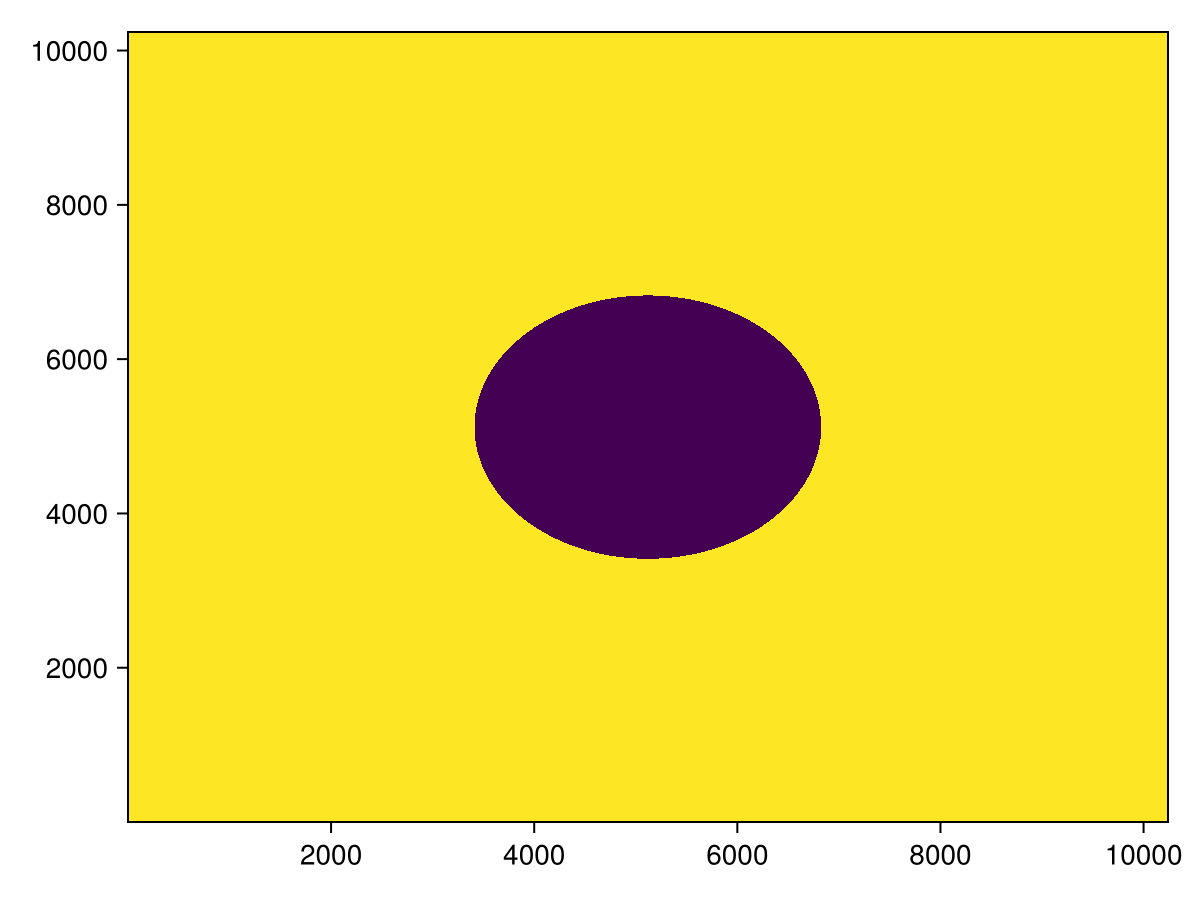

In [17]:
# initialize current and previous states to the same state
curr, prev = initialize(nx, ny)

show_heatmap(curr)

Initial average temperature: 59.76400241851807


Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


Final average temperature: 59.66948531363336
 33.202584 seconds (1.94 M allocations: 1.690 GiB, 0.12% gc time, 8.46% compilation time)


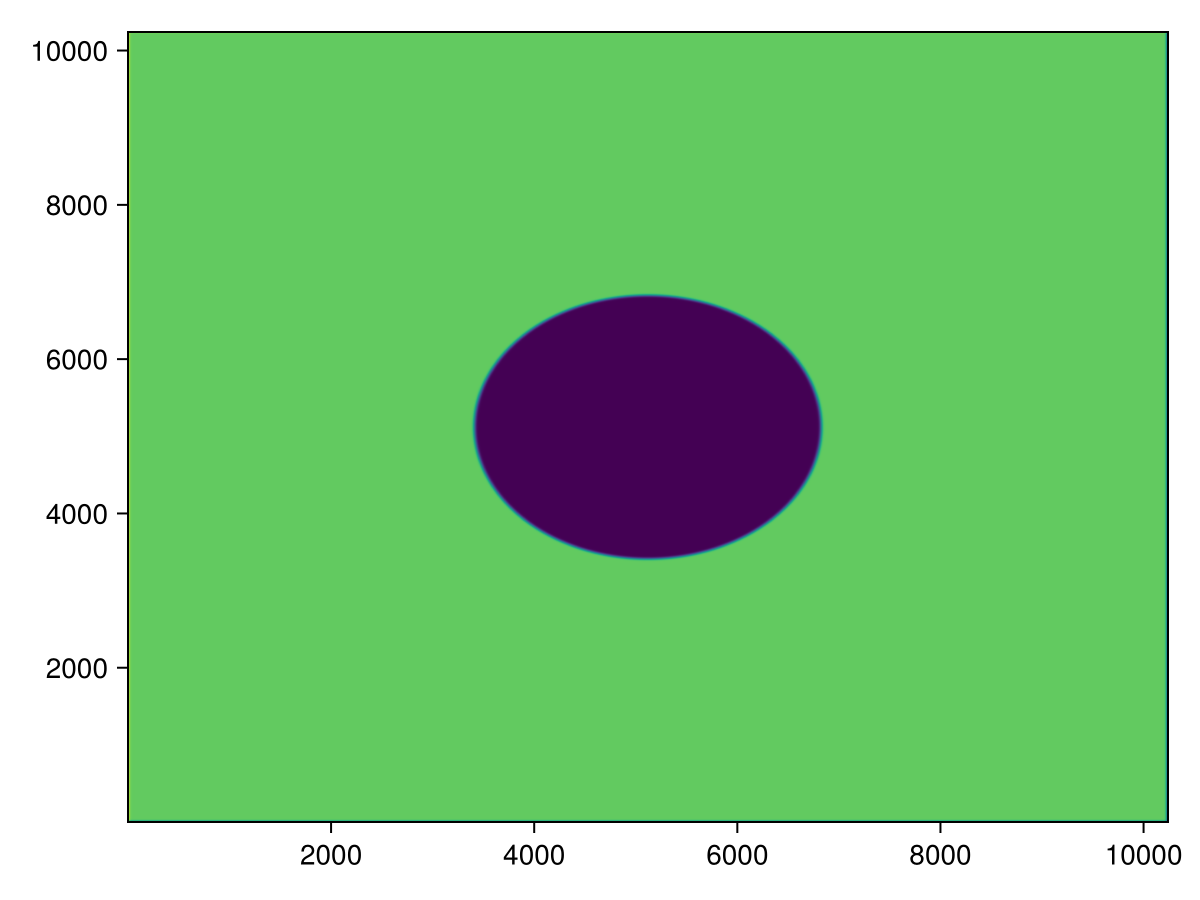

In [18]:
# simulate temperature evolution for nsteps
@time simulate_cpu!(curr, prev, nsteps)

show_heatmap(curr)

## GPU (CUDA) Implementation of the Discretized Heat Equation

In [19]:
function calculate_cuda!(currdata, prevdata, dx2, dy2, nx, ny, a, dt)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    j = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    if i > 1 && j > 1 && i < nx+2 && j < ny+2
        @inbounds xderiv = (prevdata[i-1, j] - 2.0 * prevdata[i, j] + prevdata[i+1, j]) / dx2
        @inbounds yderiv = (prevdata[i, j-1] - 2.0 * prevdata[i, j] + prevdata[i, j+1]) / dy2
        @inbounds currdata[i, j] = prevdata[i, j] + a * dt * (xderiv + yderiv)
    end
    
    return
end

calculate_cuda! (generic function with 1 method)

In [20]:
function simulate_gpu!(curr::Field, prev::Field, nsteps::Integer)
    println("Initial average temperature: $(average_temperature(curr))")

    # Diffusion constant
    α = 0.5
    # Largest stable time step
    dt = curr.dx^2 * curr.dy^2 / (2.0 * α * (curr.dx^2 + curr.dy^2))
    
    # display a nice progress bar
    p = Progress(nsteps)

    for i = 1:nsteps
        # calculate new state based on previous state
        
        nx, ny = size(curr.data) .- 2   
        xthreads = ythreads = 32
        xblocks, yblocks = cld(curr.nx, xthreads), cld(curr.ny, ythreads)
        @cuda threads=(xthreads, ythreads) blocks = (xblocks, yblocks) calculate_cuda!(curr.data, prev.data, curr.dx^2, curr.dy^2, nx, ny, α, dt)

        # swap current and previous fields
        swap_fields!(curr, prev)

        # increment the progress bar
        next!(p)
    end 

    println("Final average temperature: $(average_temperature(curr))")
end

simulate_gpu! (generic function with 1 method)

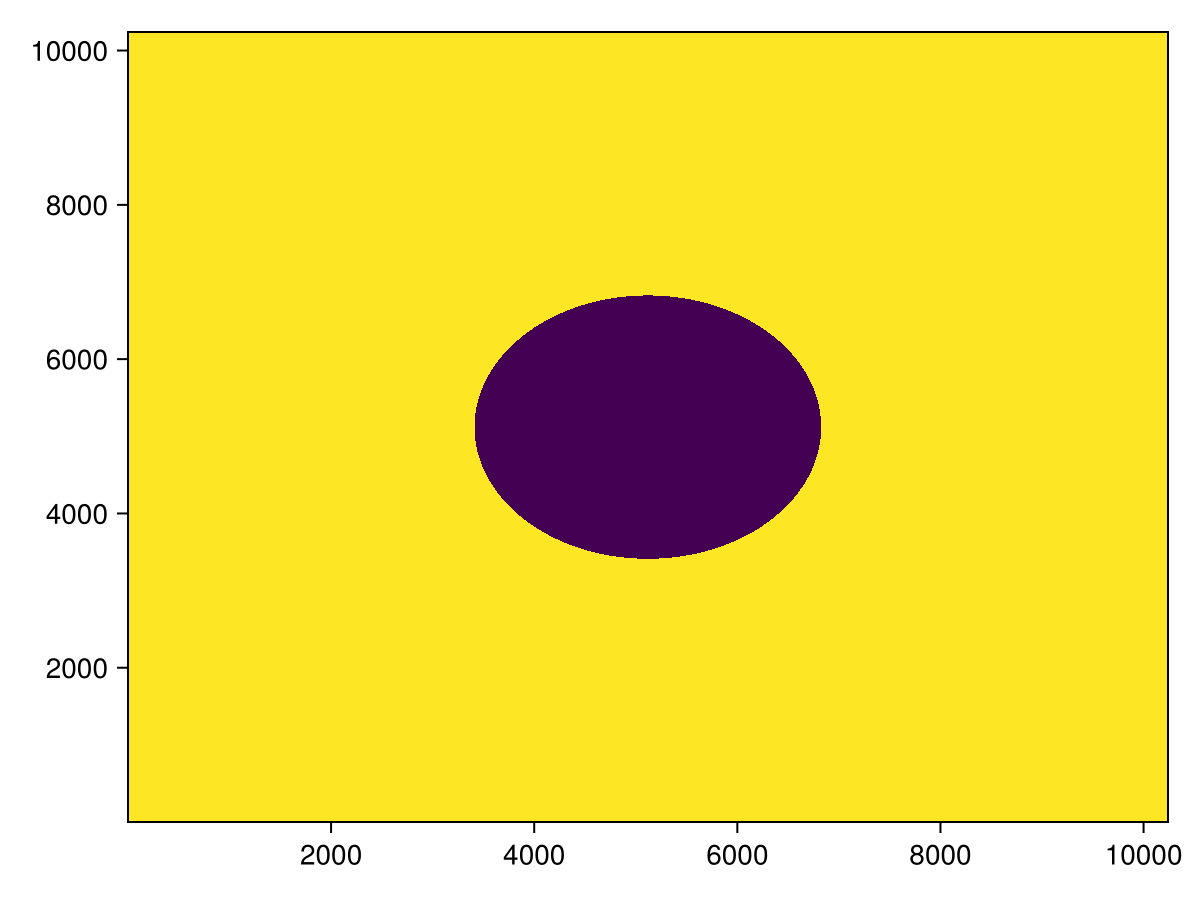

In [21]:
# initialize data on CPU and move it to GPU
curr, prev = initialize(nx, ny, CuArray)

show_heatmap(curr)

Initial average temperature: 59.76400241851807


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Final average temperature: 59.734468711088795
 10.429067 seconds (10.85 M allocations: 750.088 MiB, 1.88% gc time, 80.85% compilation time: 4% of which was recompilation)


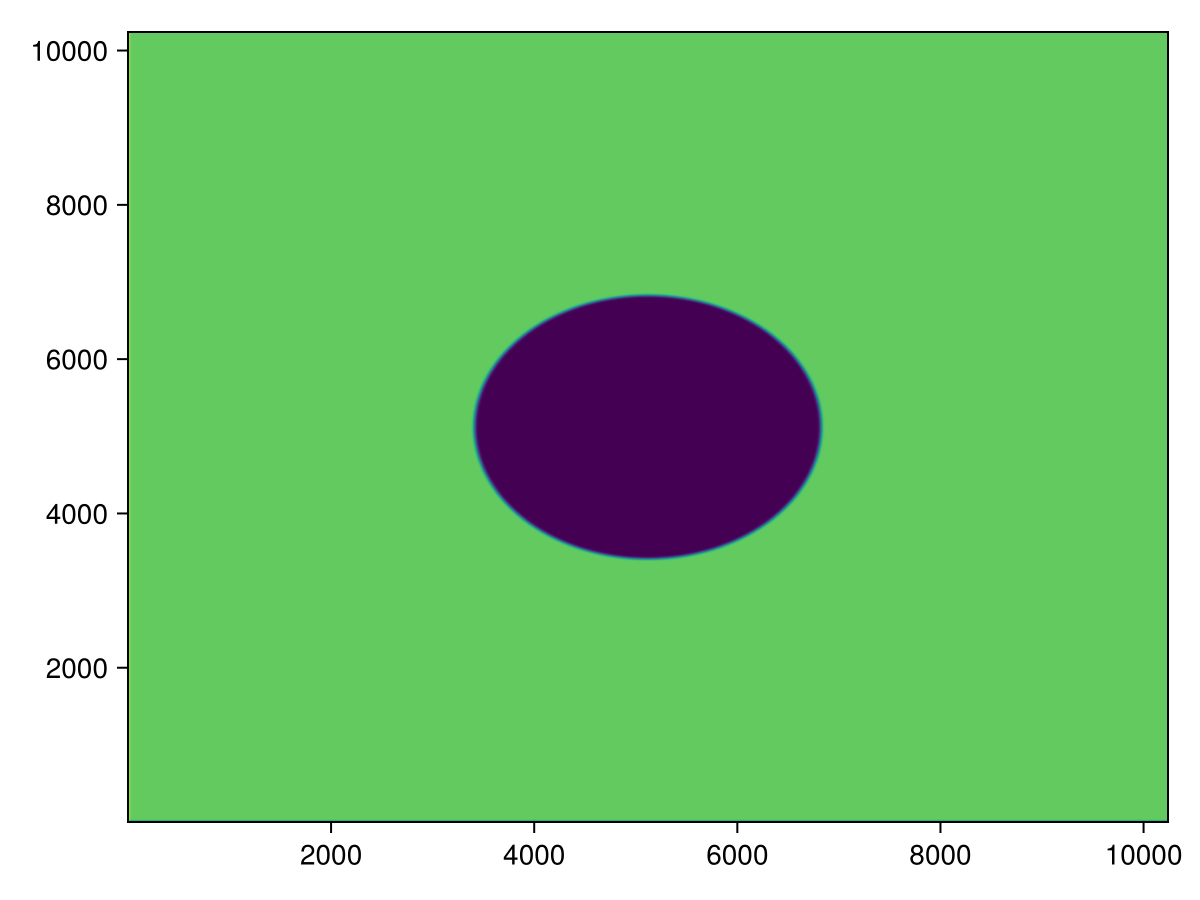

In [22]:
# simulate temperature evolution for nsteps
@time simulate_gpu!(curr, prev, nsteps)

show_heatmap(curr)

Initial average temperature: 59.734468711088795
Final average temperature: 59.663490843418884
 13.563114 seconds (90.64 k allocations: 2.930 MiB)


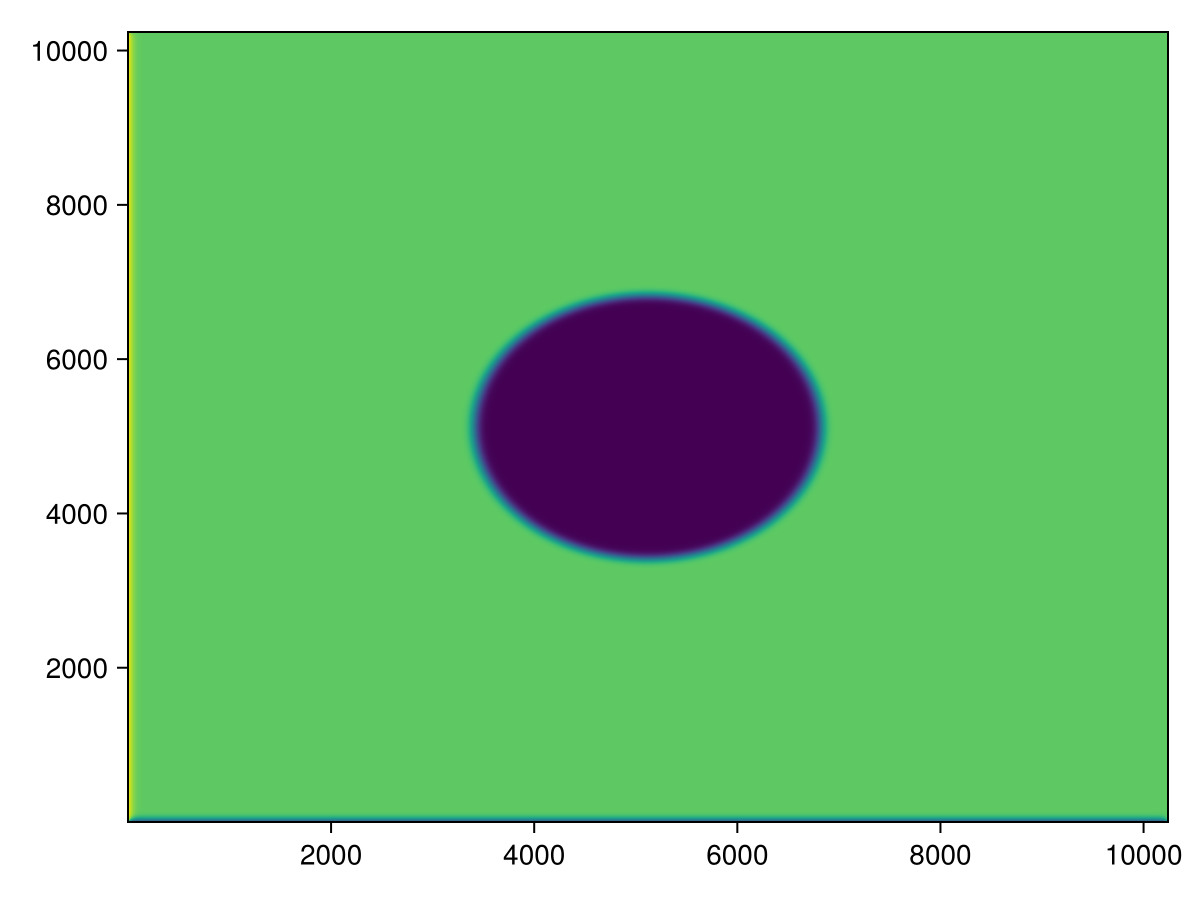

In [23]:
# simulate temperature evolution for 5000 additional steps
@time simulate_gpu!(curr, prev, 5000)

show_heatmap(curr)

## KernelAbstractions Implementation of the Discretized Heat Equation

In [24]:
using KernelAbstractions

In [25]:
# add all options for different backends and array types
DEV = :NVIDIA

if DEV == :NVIDIA
    using CUDA
    ArrayKA = CUDA.CuArray
    Backend = CUDA.CUDABackend()
elseif DEV == :AMD
    using AMDGPU
    ArrayKA = AMDGPU.ROCArray
    Backend = AMDGPU.ROCBackend()
elseif DEV == :oneAPI
    using oneAPI 
    ArrayKA = oneAPI.oneArray
    Backend = oneAPI.oneAPIBackend()
elseif DEV == :Metal
    using Metal 
    ArrayKA = Metal.MtlArray
    Backend = Metal.MetalBackend()
else DEV == :CPU
    ArrayKA = Array
    Backend = CPU()
end

CUDABackend(false, false)

In [26]:
@kernel function calculate_kernel!(currdata, prevdata, dx2, dy2, nx, ny, a, dt)
    i, j = @index(Global, NTuple)
    
    if i > 1 && j > 1 && i < nx+2 && j < ny+2
        @inbounds xderiv = (prevdata[i-1, j] - 2.0 * prevdata[i, j] + prevdata[i+1, j]) / dx2
        @inbounds yderiv = (prevdata[i, j-1] - 2.0 * prevdata[i, j] + prevdata[i, j+1]) / dy2
        @inbounds currdata[i, j] = prevdata[i, j] + a * dt * (xderiv + yderiv)
    end
end

calculate_kernel! (generic function with 4 methods)

In [27]:
function simulate_KA!(curr::Field, prev::Field, nsteps::Integer)
    println("Initial average temperature: $(average_temperature(curr))")

    # Diffusion constant
    α = 1.0    
    # Largest stable time step
    dt = curr.dx^2 * curr.dy^2 / (2.0 * α * (curr.dx^2 + curr.dy^2))
    
    # display a nice progress bar
    p = Progress(nsteps)

    for i = 1:nsteps
        # calculate new state based on previous state
        
        nx, ny = size(curr.data) .- 2  

        workgroupsize = (32, 32)
        kernel! = calculate_kernel!(Backend, workgroupsize)
        kernel!(curr.data, prev.data, curr.dx^2, curr.dy^2, nx, ny, α, dt, ndrange=(nx, ny))
        KernelAbstractions.synchronize(Backend)

        # swap current and previous fields
        swap_fields!(curr, prev)

        # increment the progress bar
        next!(p)
    end 

    println("Final average temperature: $(average_temperature(curr))")
end

simulate_KA! (generic function with 1 method)

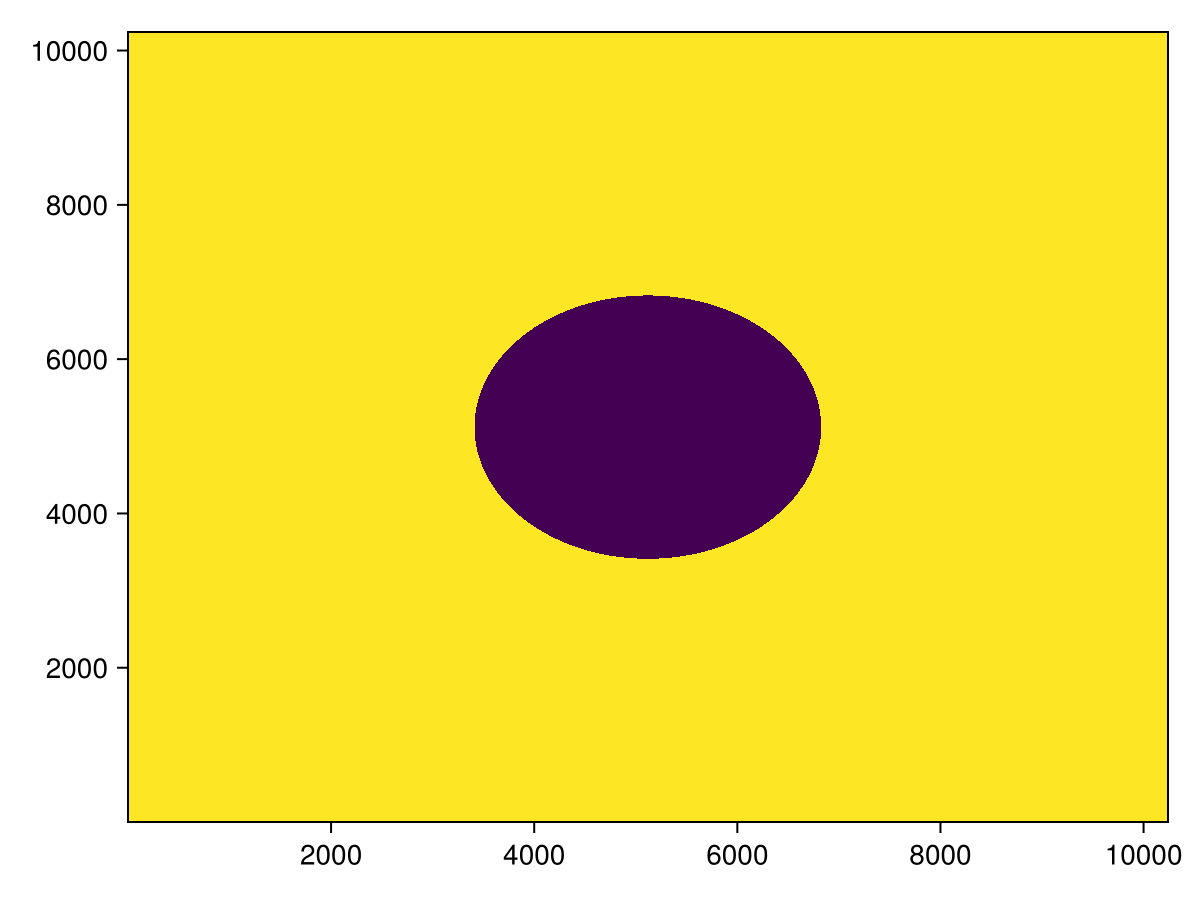

In [28]:
# initialize data on CPU and move it to GPU
curr, prev = initialize(nx, ny, ArrayKA)

show_heatmap(curr)

Initial average temperature: 59.76400241851807


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Final average temperature: 59.734468711088795
  2.210148 seconds (1.20 M allocations: 80.952 MiB, 0.55% gc time, 22.07% compilation time)


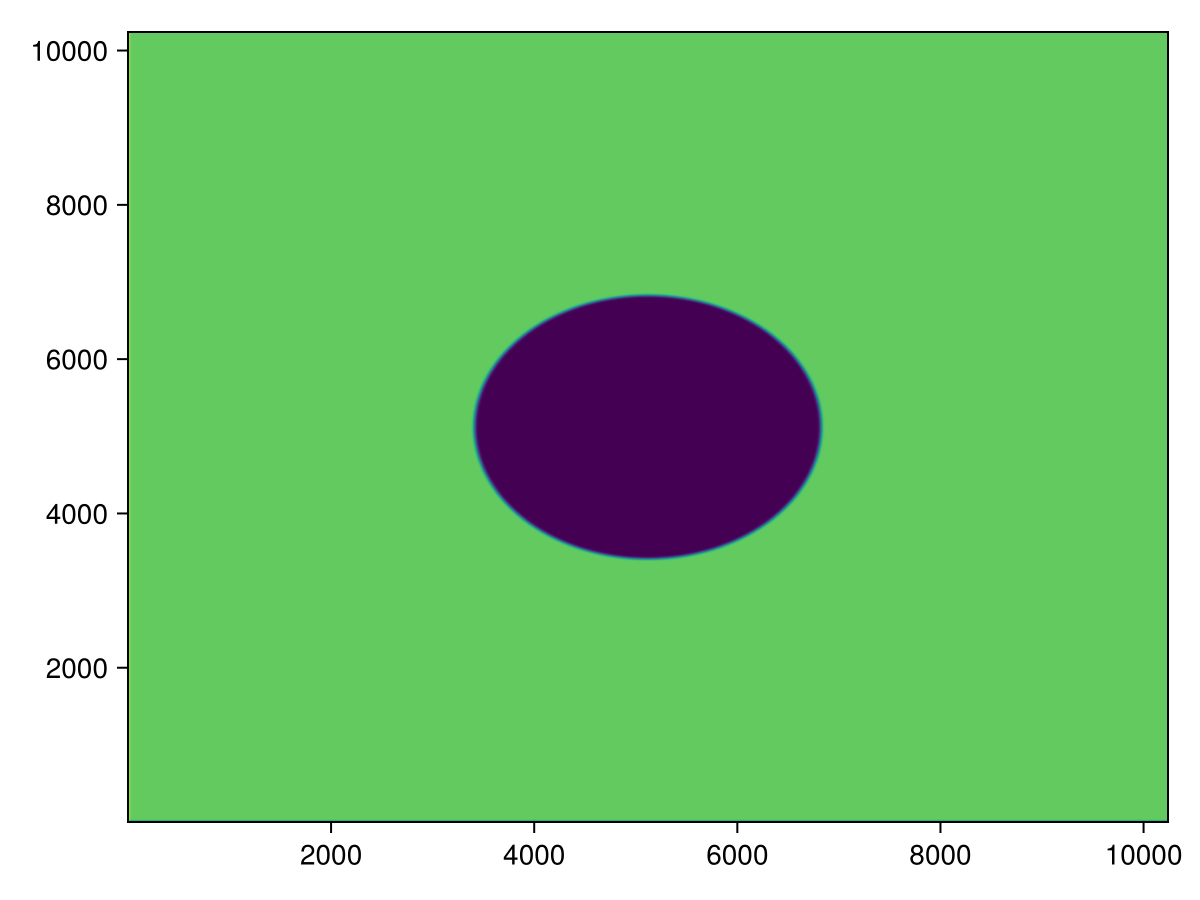

In [29]:
# simulate temperature evolution for nsteps
@time simulate_KA!(curr, prev, nsteps)

show_heatmap(curr)

Initial average temperature: 59.734468711088795


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


Final average temperature: 59.663490843418884
 15.499973 seconds (430.77 k allocations: 13.928 MiB)


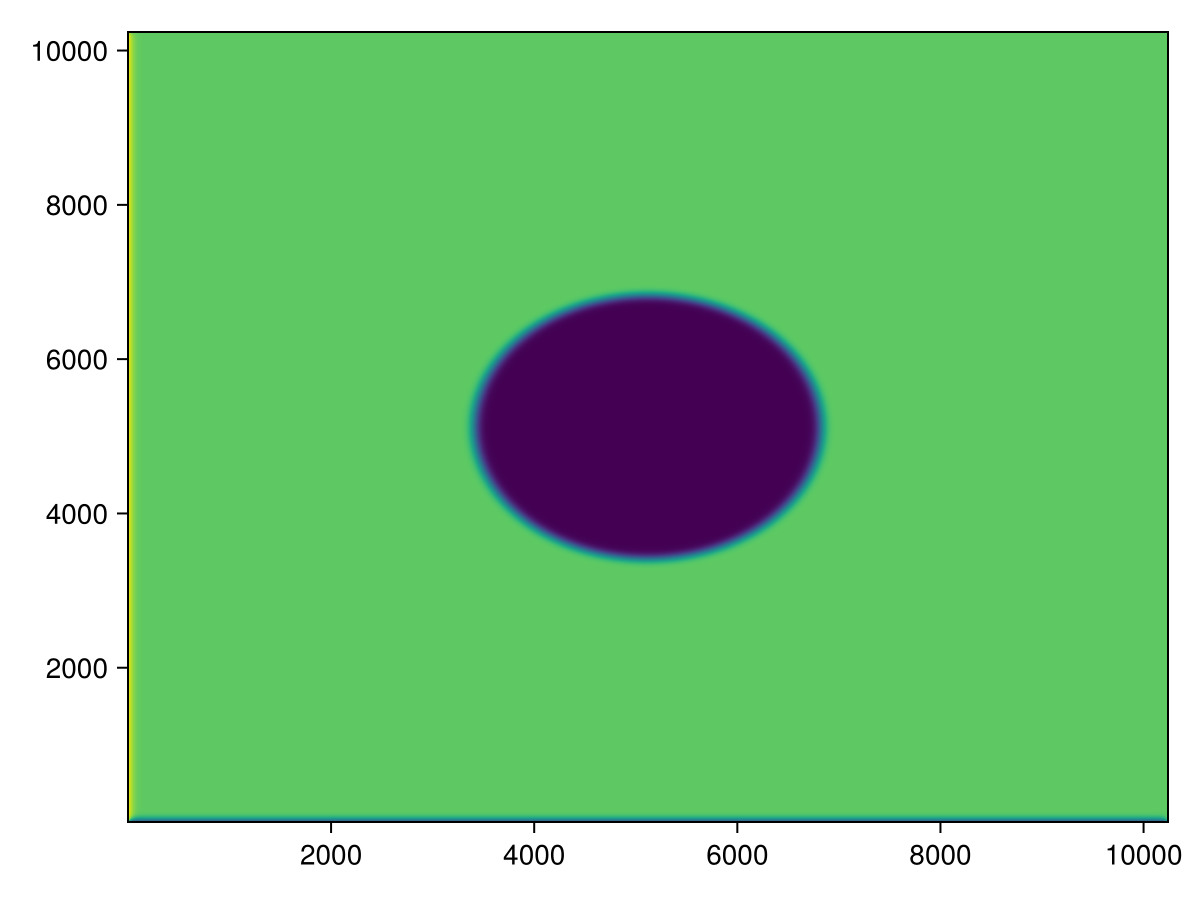

In [30]:
# simulate temperature evolution for 5000 additional steps
@time simulate_KA!(curr, prev, 5000)

show_heatmap(curr)

In [31]:
function set_KA(DEV)
    if DEV == :NVIDIA
        ArrayKA = CUDA.CuArray
        Backend = CUDA.CUDABackend()
    else DEV == :CPU
        ArrayKA = Array
        Backend = CPU()
    end
    return ArrayKA, Backend
end

set_KA (generic function with 1 method)

# Benchmarking

In [36]:
nsteps = 2000
timing = zeros(4)
#Multithreading 
println("Multithreading")
curr, prev = initialize(nx, ny)
timing[1] = @elapsed simulate_cpu!(curr, prev, nsteps)
println("Time:", timing[1])

#GPU(CUDA)
println("\nCUDA")
curr, prev = initialize(nx, ny, CuArray)
timing[2] = @elapsed simulate_gpu!(curr, prev, nsteps)
println("Time:", timing[2])

#Kernel Abstraction(CPU) 
println("\nKernel Abstraction(CPU)")
ArrayKA, Backend = set_KA(:CPU)
curr, prev = initialize(nx, ny, ArrayKA)
timing[3] = @elapsed simulate_KA!(curr, prev, nsteps)
println("Time:", timing[3])

#Kernel Abstraction(CUDA) 
println("\nKernel Abstraction(CUDA)")
ArrayKA, Backend = set_KA(:NVIDIA)
curr, prev = initialize(nx, ny, ArrayKA)
timing[4] = @elapsed simulate_KA!(curr, prev, nsteps)
println("Time:", timing[4])

Multithreading
Initial average temperature: 59.76400241851807


Progress: 100%|█████████████████████████████████████████| Time: 0:02:05


Final average temperature: 59.57126778272822
Time:125.898366889

CUDA
Initial average temperature: 59.76400241851807
Final average temperature: 59.70377874086522
Time:5.481762894

Kernel Abstraction(CPU)
Initial average temperature: 59.76400241851807


Progress: 100%|█████████████████████████████████████████| Time: 0:02:29


Final average temperature: 59.703778740865204
Time:149.647226045

Kernel Abstraction(CUDA)
Initial average temperature: 59.76400241851807


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Final average temperature: 59.70377874086522
Time:6.245431125


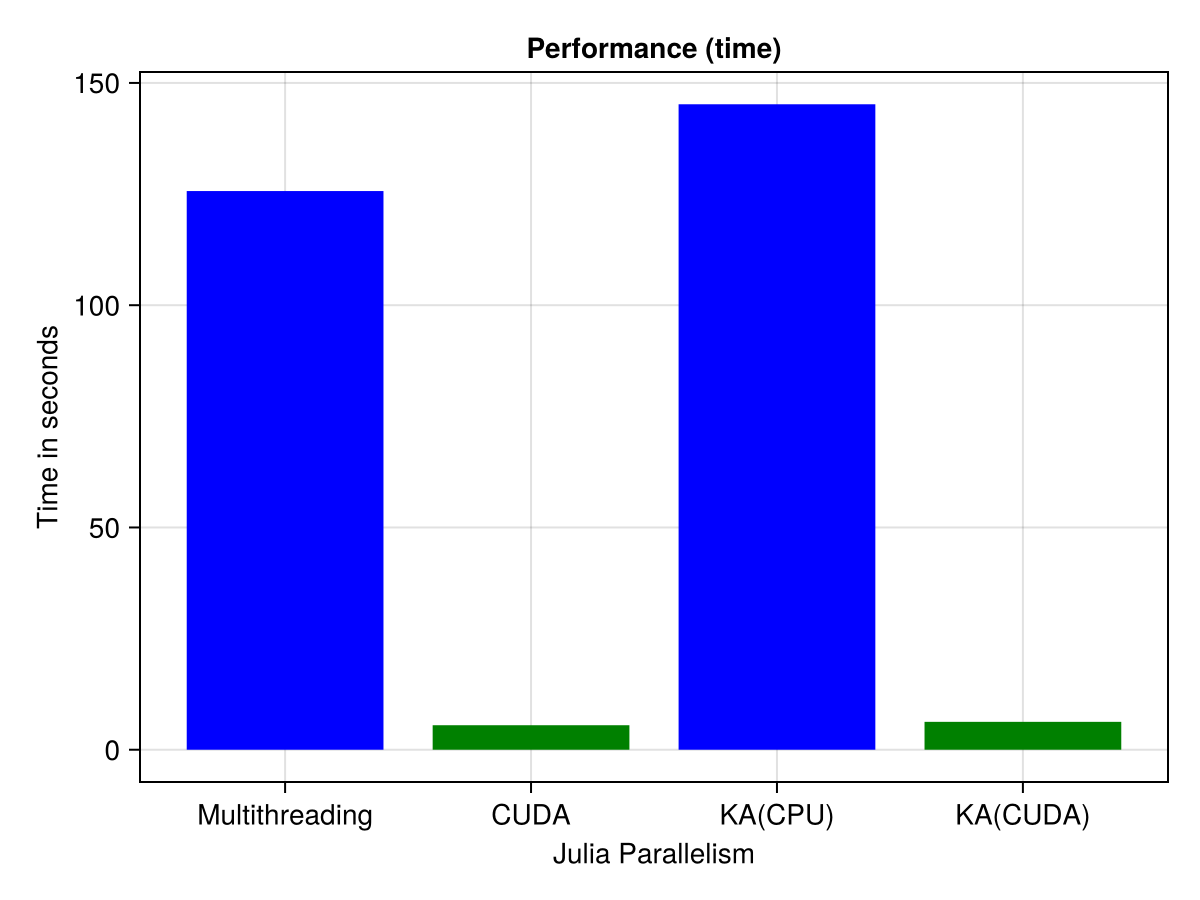

In [33]:

# Data
categories = ["Multithreading", "CUDA", "KA(CPU)", "KA(CUDA)"]
x_indices = 1:length(categories)
colors = [:blue, :green, :blue, :green]  # Define different colors for each bar

# Create the figure
fig = Figure()
ax = Axis(fig[1, 1], title = "Performance (time)", xlabel = "Julia Parallelism", 
    ylabel = "Time in seconds", xticks = (x_indices, categories))

# Create the bar plot
barplot!(ax, x_indices, timing, color = colors)

# Display the figure
fig